In [1]:
%matplotlib inline
import calendar
import configparser
import glob
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get API key for HydAPI
config = configparser.RawConfigParser()
config.read(".nve-hydapi-key")
api_key = config.get("Auth", "key")

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# Update RID flow datasets

Each year, updated flow datasets (both modelled and observed) are obtained from NVE and added to RESA2.

In [3]:
# Year of interest
year = 2021

## 1. Observed discharge

Observed time series are used **only** for the 11 main rivers - all other calculations are based on modelled flows (from HBV). This notebook uses NVE's HydAPI to download data for the relevant stations where possible. Other datasets must be obtained directly from NVE (e-mail Trine Fjeldstad). Note that more than 11 discharge stations are involved, because at some chemistry sampling locations the flow is the sum of several NVE discharge series. Note also the following:

 * Chemistry station 29613 should ideally use the sum of NVE series 16.133 and 16.153, but the latter is no longer available. We simply assume the input from 16.153 is constant at 10 $m^3/s$ (which is roughly equal to the long-term average) <br><br>
 
 * The discharge for chemistry station 29614 is **either** NVE station 21.71 **or** 21.11. 21.11 is usually available first, but can check 21.71 too <br><br> 
 
 * Discharge data for chemistry stations 29617 (NVE ID 2.605) and 36225 (NVE ID 6.78) are often delayed. Need to contact Trine at NVE early to avoid problems later.

### 1.1. Discharge stations

The discharge stations associated with the 11 main water chemistry sampling locations are shown in the dataframe below.

In [4]:
xl_path = r"../data/rid_resa_nve_discharge_stations.xlsx"
resa_nve_df = pd.read_excel(xl_path, sheet_name="observed_stns")

with pd.option_context("display.max_colwidth", None):
    display(resa_nve_df)

,station_id,station_code,nve_id,dis_station_id,comment
0,29612,BUSEDRA,12.285.0,57,Not available via API
1,29613,TELESKI,16.133.0,59,"Actually (16.153 + 16.133), but 16.153 no longer monitored. Assume constant at 10 m3/s and add to 16.133"
2,29614,VAGEOTR,21.11.0,487,Not available via API
3,29615,VESENUM,15.61.0,58,NaN
4,29617,ØSTEGLO,2.605.0,56,NaN
5,29778,STREORK,121.22.0,348,NaN
6,29779,FINEALT,212.11.0,386,NaN
7,29782,NOREVEF,151.28.0,351,"Used to be 151.5.0, but this is not available via API. 151.28.0 seems identical"
8,29783,ROGEORR,28.7.0,355,NaN
9,29821,HOREVOS,62.5.0,546,NaN


### 1.2. Data from HydAPI

In [5]:
# Get stations from HydAPI
nve_stn_df = nivapy.da.get_nve_hydapi_stations(api_key=api_key)
nve_stn_ids = resa_nve_df["nve_id"].values
nve_stn_df = nve_stn_df.query("station_id in @nve_stn_ids")
print(f"{len(nve_stn_df)} out of {len(resa_nve_df)} stations found in HydAPI:")
nve_stn_df

9 out of 11 stations found in HydAPI:


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
225,121.22.0,Syrstad,63.03225,9.72771,233461,7000123,147,Orkla,5059,Orkland,...,448.0000,520.0000,788.0000,1043.0000,2.4200,2.8700,3.1600,4.1400,4.9500,"[{'parameterName': 'Vannstand', 'parameter': 1..."
388,15.61.0,Holmfoss i Numedalslågen,59.18906,9.99414,214153,6571840,20,Numedalslågen,3805,Larvik,...,553.5322,668.7913,795.9551,992.0781,4.9181,5.3517,5.8016,6.2377,6.8213,"[{'parameterName': 'Vannstand', 'parameter': 1..."
397,151.28.0,Laksfors,65.62155,13.29156,421320,7278797,40,Vefsna,1825,Grane,...,1266.0000,1427.0000,1580.0000,1779.0000,4.7400,5.1500,5.4300,5.6900,5.9900,"[{'parameterName': 'Vannstand', 'parameter': 1..."
471,16.133.0,Skotfoss,59.20771,9.52788,187736,6576005,16,Skiensvassdraget,3807,Skien,...,920.0000,1070.0000,1210.0000,1400.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
889,2.605.0,Solbergfoss,59.63733,11.15354,283189,6617306,98,Glommavassdraget,3014,Indre Østfold,...,2677.0000,3046.0000,3217.0000,3492.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
1046,212.11.0,Kista,69.82630,23.51681,826880,7769359,62,Altavassdraget,5403,Alta,...,835.1331,959.0339,1064.7242,1184.6863,3.4079,3.9221,4.2081,4.4363,4.6806,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1212,28.7.0,Haugland,58.69291,5.64757,-40981,6543711,19,Hååna,1121,Time,...,80.9847,92.1915,103.5736,120.7441,1.8429,2.0078,2.1524,2.2925,2.4932,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1438,6.78.0,Alna v/Kvernerbyen,59.90471,10.79156,264693,6648281,30,Alna,0301,Oslo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1471,62.5.0,Bulken (Vangsvatnet),60.62868,6.29254,24518,6753006,51,Vossovassdraget,4621,Voss,...,470.0000,530.0000,580.0000,660.0000,3.6800,4.2700,4.7700,5.1800,5.8300,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [6]:
# Get discharge
par_ids = [1001]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"
q_df = nivapy.da.query_nve_hydapi(
    nve_stn_ids, par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-01 11:00:00+00:00,40.75436,m³/s,0,2
1,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-02 11:00:00+00:00,38.54340,m³/s,0,2
2,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-03 11:00:00+00:00,37.70287,m³/s,0,2
3,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-04 11:00:00+00:00,40.63923,m³/s,0,2
4,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-05 11:00:00+00:00,39.39777,m³/s,0,2


In [7]:
# Check number of records as expected
days = 366 if calendar.isleap(year) else 365
assert len(q_df) == len(nve_stn_df) * days, "Number of records is not as expected."

# Check quality control level
print(
    "The following series have not completed quality control and will be dropped (i.e. 'quality' < 3;"
)
print("see https://hydapi.nve.no/UserDocumentation/ for details):\n")
print(q_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Drop quality < 3
q_df = q_df.query("quality == 3")

# Check for NaN
if pd.isna(q_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        q_df[pd.isna(q_df["value"])][["station_id", "station_name"]].drop_duplicates()
    )

# Check for negative
if (q_df["value"] < 0).sum() > 0:
    print("\n\nThe following records contain values <0:\n")
    print(q_df[q_df["value"] < 0][["station_id", "station_name"]].drop_duplicates())

The following series have not completed quality control and will be dropped (i.e. 'quality' < 3;
see https://hydapi.nve.no/UserDocumentation/ for details):

     station_id        station_name
0      151.28.0            Laksfors
365      6.78.0  Alna v/Kvernerbyen
1095   16.133.0            Skotfoss
2555    2.605.0         Solbergfoss


Based on the output above we can **make a data request to NVE**. This typically involves requesting the records for stations **21.11.0** and **12.285.0** (which are not available via HydAPI), **plus** any sites that haven't yet finished quality control (listed above).

The cell below uploads the valid HydAPI data to RESA2.

In [8]:
def process_hydapi_data_for_resa(resa_nve_df, q_df, eng):
    """Process discharge time series from HydAPI and prepare them for upload to RESA2.

    Args
        resa_nve_df: Dataframe of RESA stations with NVE IDs
        q_df:        Dataframe of discharge data from HydAPI
        eng:         Obj. Active database connection object for RESA2

    Returns
        Dataframe.
    """
    df_list = []

    # Loop over Hydra II data
    for idx, row in resa_nve_df.iterrows():
        nve_id = row["nve_id"]
        dis_stn_id = row["dis_station_id"]

        # Get flow for station
        q_stn_df = q_df.query("station_id == @nve_id").copy()

        if len(q_stn_df) == 0:
            print(f"No data for NVE ID {nve_id}.")

        else:
            assert len(q_stn_df) == days

            # Remove HH:MM:SS part from dates
            q_stn_df.set_index("datetime", inplace=True)
            q_stn_df = q_stn_df.resample("D").mean()
            q_stn_df.reset_index(inplace=True)
            q_stn_df["datetime"] = q_stn_df["datetime"].dt.date

            # Linear interpolation and back-filling of NaN
            q_stn_df["value"].interpolate(method="linear", inplace=True)
            q_stn_df["value"].fillna(method="backfill", inplace=True)

            # Add 10 m3/s to 16.133 (RESA2 discharge station ID 59)
            if dis_stn_id == 59:
                q_stn_df["value"] = q_stn_df["value"] + 10

            # Add other required cols and tidy
            q_stn_df["dis_station_id"] = dis_stn_id
            q_stn_df["xcomment"] = np.nan
            q_stn_df["xvalue"] = q_stn_df["value"]
            q_stn_df["xdate"] = q_stn_df["datetime"]

            # Reorder cols
            q_stn_df = q_stn_df[["dis_station_id", "xdate", "xvalue", "xcomment"]]

            # Append to output
            df_list.append(q_stn_df)

            # Check whether data already exist for this year
            sql = (
                "SELECT count(*) FROM resa2.discharge_values "
                "WHERE dis_station_id = %s "
                "AND EXTRACT(YEAR FROM xdate) = %s " % (dis_stn_id, year)
            )
            cnt_df = pd.read_sql(sql, eng)
            cnt = cnt_df.iloc[0, 0]
            if cnt > 0:
                print(
                    "%s data already exist for NVE "
                    "station %s (RESA2 ID %s)." % (cnt, nve_id, dis_stn_id)
                )

    hydapi_q_df = pd.concat(df_list, axis=0)

    return hydapi_q_df

In [9]:
hydapi_q_df = process_hydapi_data_for_resa(resa_nve_df, q_df, eng)
hydapi_q_df.head()

No data for NVE ID 12.285.0.
No data for NVE ID 16.133.0.
No data for NVE ID 21.11.0.
No data for NVE ID 2.605.0.
No data for NVE ID 151.28.0.
No data for NVE ID 6.78.0.


,dis_station_id,xdate,xvalue,xcomment
0,58,2021-01-01,134.6088,NaN
1,58,2021-01-02,126.6972,NaN
2,58,2021-01-03,131.7123,NaN
3,58,2021-01-04,130.7991,NaN
4,58,2021-01-05,119.8667,NaN


In [10]:
# # Add new rows to database
# hydapi_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

1825

### 1.3. Data from Trine

Once all the missing datasets identified above have been obtained from NVE, the following code can be used to add them to the database.

In [11]:
# Folder containing data from Trine
tri_fold = f"../../../Data/nve_observed/{year}-{year - 1999}/from_trine"

days = 366 if calendar.isleap(year) else 365

# List to store output
df_list = []

# Get list of files from Trine to process
search_path = os.path.join(tri_fold, "*.csv")
file_list = glob.glob(search_path)

# Loop over files from Trine
for file_path in file_list:
    # Get RESA station ID
    nve_id = os.path.split(file_path)[1].split("_")[0] + ".0"
    dis_stn_id = resa_nve_df.query("nve_id == @nve_id")["dis_station_id"].iloc[0]

    # Parse file
    q_stn_df = pd.read_csv(
        file_path,
        skiprows=1,
        index_col=0,
        parse_dates=True,
        header=None,
        sep=";",
        names=["xdate", "xvalue"],
        na_values="-9999",
        encoding="cp1252",
    )

    # Get just records for year of interest
    q_stn_df = q_stn_df.truncate(
        before="%s-01-01" % year, after="%s-01-01" % (year + 1)
    )

    # Remove HH:MM:SS part from dates
    q_stn_df = q_stn_df.resample("D").mean()
    q_stn_df.reset_index(inplace=True)
    q_stn_df["xdate"] = q_stn_df["xdate"].dt.date

    # Linear interpolation and back-filling of NaN
    q_stn_df["xvalue"].interpolate(method="linear", inplace=True)
    q_stn_df["xvalue"].fillna(method="backfill", inplace=True)

    # Add 10 m3/s to 16.133 (RESA2 ID 59)
    if dis_stn_id == 59:
        q_stn_df["xvalue"] = q_stn_df["xvalue"] + 10.0

    # Add dis_id and tidy
    q_stn_df["dis_station_id"] = dis_stn_id
    q_stn_df["xcomment"] = np.nan

    # Reorder cols
    q_stn_df = q_stn_df[["dis_station_id", "xdate", "xvalue", "xcomment"]]

    # Append to output
    df_list.append(q_stn_df)

# Stack data
tri_q_df = pd.concat(df_list, axis=0)

assert (
    len(tri_q_df) == len(file_list) * days
), "Datasets has an unexpected number of records."
assert tri_q_df["xvalue"].dtypes == np.float64, 'Check for text in "xvalue" column.'
assert pd.isna(tri_q_df["xvalue"]).sum() == 0, 'Check for NaN in "xvalue" column.'

tri_q_df.head()

,dis_station_id,xdate,xvalue,xcomment
0,57,2021-01-01,441.60,NaN
1,57,2021-01-02,426.07,NaN
2,57,2021-01-03,418.39,NaN
3,57,2021-01-04,410.65,NaN
4,57,2021-01-05,409.89,NaN


In [12]:
# # Add new rows to database
# tri_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

1460

## 2. Modelled discharge

Each year, Stein Beldring supplies modelled data from HBV for the period from 1990 to the year of interest. These datasets are stored locally here:

    ...Elveovervakingsprogrammet\Data\hbv_modelled

and on the network here:

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Vannføring\Modellert

The flow files are named e.g. `hbv_00000001.var`, where the number corresponds to the NVE "vassdragsområde". These are listed in *vassomr.pdf* in the above folder, and they're also included in RESA2's `DISCHARGE_STATIONS` table. The vassdragsområde numbers are stored in the `NVE_SERINUMMER` field.

Tore has an Access database in e.g.

K:\Avdeling\Vass\316_Miljøinformatikk\Prosjekter\RID\Vannføring\Modellert\NVE_MODELLERT_2016\vannføring

that first deletes the modelled NVE values for each station from 1990 onwards and then adds the new data, which includes everything from 1990 plus the additional year of data. The code below does the same, and performs some basic checking of the data at the same time.

In [13]:
# Folder containing modelled data
data_fold = f"../../../Data/hbv_modelled/RID_{year}"

# Get a list of files to process (only interested in flow here)
search_path = os.path.join(data_fold, "hbv_*.var")
file_list = glob.glob(search_path)

# Get number of days between 1990 and year of interest
days_new = len(pd.date_range(start="1990-01-01", end="%s-12-31" % year, freq="D"))

# Get number of days between 1990 and year before
days_old = len(pd.date_range(start="1990-01-01", end="%s-12-31" % (year - 1), freq="D"))

# Loop over files
for file_path in file_list:
    # Get name and reg. nr.
    name = os.path.split(file_path)[1]
    reg_nr = int(name.split("_")[1][:-4])
    print(f"Processing {name}.")

    # Get RESA2 station ID
    sql = (
        "SELECT dis_station_id FROM resa2.discharge_stations "
        "WHERE nve_serienummer = '%s'" % reg_nr
    )
    dis_id = pd.read_sql_query(sql, eng).iloc[0, 0]

    # Check number of post-1990 records already in db
    # (should equal days_old)
    sql = (
        "SELECT COUNT(*) FROM resa2.discharge_values "
        "WHERE dis_station_id = %s "
        "AND xdate >= DATE '1990-01-01'" % dis_id
    )
    cnt_old = pd.read_sql_query(sql, eng).iloc[0, 0]
    assert cnt_old == days_old, "Unexpected number of records already in database."

    # Read new data
    df = pd.read_csv(
        file_path, delim_whitespace=True, header=None, names=["XDATE", "XVALUE"]
    )

    # Convert dates
    df["XDATE"] = pd.to_datetime(df["XDATE"], format="%Y%m%d/1200")

    # Check st, end and length
    assert df["XDATE"].iloc[0] == pd.Timestamp(
        "1990-01-01"
    ), "New series does not start on 01/01/1990."
    assert df["XDATE"].iloc[-1] == pd.Timestamp("%s-12-31" % year), (
        "New series does not end on 31/12/%s." % year
    )
    assert len(df) == days_new, "Unexpected length for new series."

    # Add station ID to df
    df["DIS_STATION_ID"] = dis_id

#     # Drop existing rows post-1990 for this site
#     sql = (
#         "DELETE FROM resa2.discharge_values "
#         "WHERE dis_station_id = %s "
#         "AND xdate >= DATE '1990-01-01'" % dis_id
#     )
#     res = eng.execute(sql)

#     # Add new rows
#     df.to_sql(
#         "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
#     )

Processing hbv_00000001.var.
Processing hbv_00000002.var.
Processing hbv_00000003.var.
Processing hbv_00000004.var.
Processing hbv_00000005.var.
Processing hbv_00000006.var.
Processing hbv_00000007.var.
Processing hbv_00000008.var.
Processing hbv_00000009.var.
Processing hbv_00000010.var.
Processing hbv_00000011.var.
Processing hbv_00000012.var.
Processing hbv_00000013.var.
Processing hbv_00000014.var.
Processing hbv_00000015.var.
Processing hbv_00000016.var.
Processing hbv_00000017.var.
Processing hbv_00000018.var.
Processing hbv_00000019.var.
Processing hbv_00000020.var.
Processing hbv_00000021.var.
Processing hbv_00000022.var.
Processing hbv_00000023.var.
Processing hbv_00000024.var.
Processing hbv_00000025.var.
Processing hbv_00000026.var.
Processing hbv_00000027.var.
Processing hbv_00000028.var.
Processing hbv_00000029.var.
Processing hbv_00000030.var.
Processing hbv_00000031.var.
Processing hbv_00000032.var.
Processing hbv_00000033.var.
Processing hbv_00000034.var.
Processing hbv

## 3. Upload of data that has not finished quality control

**Added 12.10.2022**

There are some problems this year with data from two sites 151.28.0 (Laksfors) and 6.78.0 (Alna v/Kvernerbyen) - see e-mail from Trine Fjeldstad received 11.10.2022. These stations have not yet finished quality control. However, using [Sildre](https://sildre.nve.no/map), I have checked the 2021 data and it at least looks reasonable. The record for 151.28.0 is mostly complete, whereas that for 6.78.0 has some gaps. At this late stage, I think it is reasonable to use the data that is currently available and linearly interpolate over gaps where necessary.

**The code below should not be used unless necessary**.

In [14]:
nve_stn_ids = ["151.28.0", "6.78.0"]

In [15]:
# Get discharge
par_ids = [1001]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"
q_df = nivapy.da.query_nve_hydapi(
    nve_stn_ids, par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-01 11:00:00+00:00,40.75436,m³/s,0,2
1,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-02 11:00:00+00:00,38.54340,m³/s,0,2
2,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-03 11:00:00+00:00,37.70287,m³/s,0,2
3,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-04 11:00:00+00:00,40.63923,m³/s,0,2
4,151.28.0,Laksfors,1001,Vannføring,Discharge,Mean,2021-01-05 11:00:00+00:00,39.39777,m³/s,0,2


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

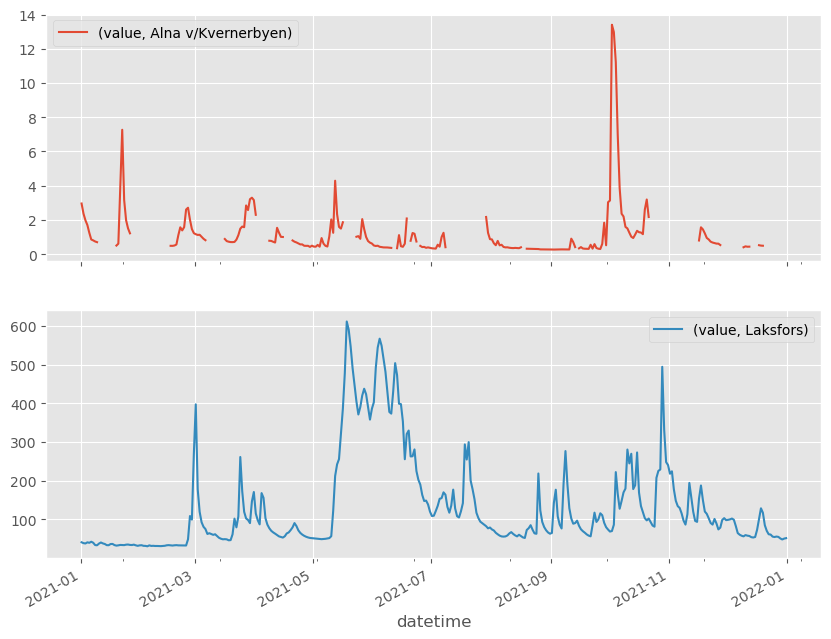

In [16]:
# Plot raw
q_df2 = q_df[["datetime", "value", "station_name"]]
q_df2.set_index(["datetime", "station_name"], inplace=True)
q_df2 = q_df2.unstack("station_name")

# Plot
q_df2.plot(subplots=True, sharex=True, figsize=(10, 8))

The code below uses the function defined above to process data from HydAPI. The only difference is that this time I'm using it with data that hasn't finished QC.

In [17]:
hydapi_q_df = process_hydapi_data_for_resa(resa_nve_df, q_df, eng)
hydapi_q_df.head()

No data for NVE ID 12.285.0.
No data for NVE ID 16.133.0.
No data for NVE ID 21.11.0.
No data for NVE ID 15.61.0.
No data for NVE ID 2.605.0.
No data for NVE ID 121.22.0.
No data for NVE ID 212.11.0.
No data for NVE ID 28.7.0.
No data for NVE ID 62.5.0.


,dis_station_id,xdate,xvalue,xcomment
0,351,2021-01-01,40.75436,NaN
1,351,2021-01-02,38.54340,NaN
2,351,2021-01-03,37.70287,NaN
3,351,2021-01-04,40.63923,NaN
4,351,2021-01-05,39.39777,NaN


array([<AxesSubplot:xlabel='xdate'>, <AxesSubplot:xlabel='xdate'>],
      dtype=object)

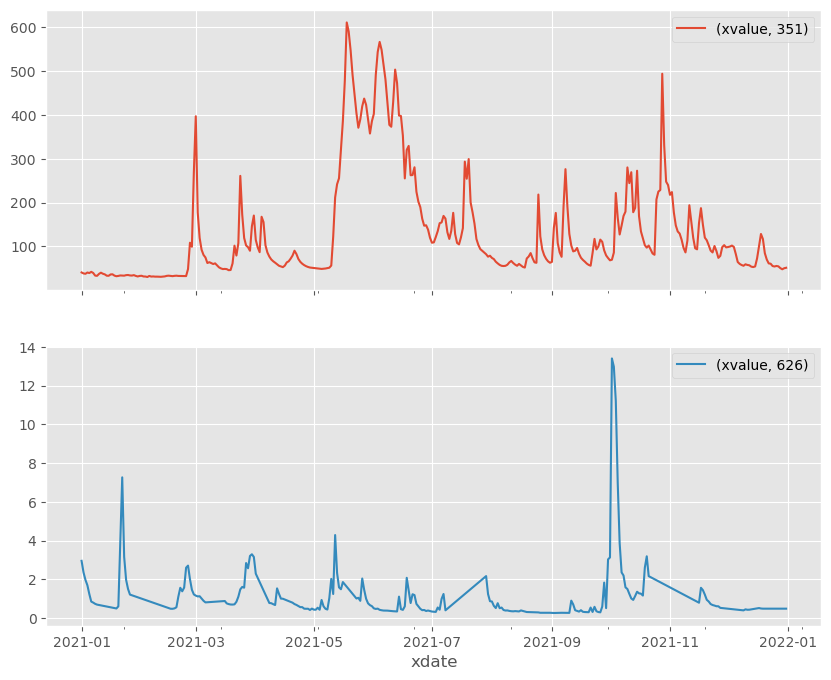

In [18]:
# Plot processed
q_df2 = hydapi_q_df[["xdate", "xvalue", "dis_station_id"]]
q_df2.set_index(["xdate", "dis_station_id"], inplace=True)
q_df2 = q_df2.unstack("dis_station_id")

# Plot
q_df2.plot(subplots=True, sharex=True, figsize=(10, 8))

In [19]:
# # Add new rows to database
# hydapi_q_df.to_sql(
#     "discharge_values", con=eng, schema="resa2", if_exists="append", index=False
# )

730